In [1]:
import sys
import os
sys.path.append('..')
import numpy as np
import pandas as pd
from models import sir
from config import get_project_root
import torchmetrics
from models.pytorchtools import EarlyStopping

In [2]:
enfermedad='covid'
DATA_FOLDER = f'{get_project_root()}/data/covid'
DATASET_PATH = f'{DATA_FOLDER}/{enfermedad}.csv'
VACCINATED_PATH = f'{DATA_FOLDER}/vaccinated-pre.csv'


In [3]:
pre_dataset = pd.read_csv(DATASET_PATH).rename(columns={'Fecha':'date', 'Casos (nuevos)': 'infected', 'Muertes (nuevos)':'deaths', 'Vacunados (nuevos-full)':'vaccinated', 'Cantidad de habitantes':'population'})[['date', 'infected', 'deaths', 'population']].fillna(0)
vaccinated = pd.read_csv(VACCINATED_PATH).rename(columns={'Day':'date', 'people_vaccinated':'vaccinated'})[['date', 'vaccinated']].fillna(0)

In [4]:
dataset = pd.concat([pre_dataset.set_index('date', drop=True), vaccinated.set_index('date', drop=True)], axis=1).dropna(axis=0, thresh=2).fillna(0)

In [5]:
dataset.head()

,infected,deaths,population,vaccinated
date,,,,
2020-01-01,0.0,0.0,45510324.0,0.0
2020-01-02,0.0,0.0,45510324.0,0.0
2020-01-03,0.0,0.0,45510324.0,0.0
2020-01-04,0.0,0.0,45510324.0,0.0
2020-01-05,0.0,0.0,45510324.0,0.0


In [6]:
exposed = []
recovered = []
for ix, row in dataset.reset_index().iterrows():
    if ix <= len(dataset)-16:
        exposed.append(dataset.iloc[ix+15]['infected'])
    else:
        exposed.append(0)
    if ix >= 15:
        recovered.append(max(dataset.infected.iloc[0:ix-15].sum() - dataset.deaths[0:ix].sum() - dataset.vaccinated[ix],0))
    else:
        recovered.append(0)

In [7]:
dataset['exposed'] = exposed
dataset['recovered'] = recovered


In [8]:
dataset.population.value_counts()

45510324.0    1035
Name: population, dtype: int64

In [9]:
max_habs = int(dataset.population.max())

In [10]:
pd.set_option('display.max_rows', None)
dataset[:1000]

,infected,deaths,population,vaccinated,exposed,recovered
date,,,,,,
2020-01-01,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-08,0.0,0.0,45510324.0,0.0,0.0,0.0
2020-01-09,0.0,0.0,45510324.0,0.0,0.0,0.0


In [11]:
susceptible_curve = max_habs - dataset.vaccinated - dataset.exposed - dataset.infected - dataset.deaths - dataset.recovered
susceptible_curve[susceptible_curve<0] = 0



In [12]:
data = pd.concat([susceptible_curve, dataset], axis=1).rename(columns={0:'susceptible'})[['susceptible', 'exposed', 'infected', 'recovered', 'deaths', 'vaccinated']][100:]


In [57]:
data[:1000]

,susceptible,exposed,infected,recovered,deaths,vaccinated
date,,,,,,
2020-04-10,45509646.0,173.0,180.0,315.0,10.0,0.0
2020-04-11,45509791.0,112.0,0.0,420.0,1.0,0.0
2020-04-12,45509533.0,111.0,167.0,506.0,7.0,0.0
2020-04-13,45509527.0,124.0,66.0,600.0,7.0,0.0
2020-04-14,45509444.0,158.0,69.0,648.0,5.0,0.0
2020-04-15,45509288.0,143.0,166.0,718.0,9.0,0.0
2020-04-16,45509145.0,104.0,128.0,943.0,4.0,0.0
2020-04-17,45509130.0,149.0,98.0,939.0,8.0,0.0
2020-04-18,45509117.0,102.0,89.0,1010.0,6.0,0.0


In [14]:
data_numpy = np.array(data)/max_habs

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [16]:
class SEIRVD(nn.Module):
    def __init__(self, epsilon=1e-7):
        super(SEIRVD, self).__init__()
        self.lambda1 = nn.Linear(1,1, bias = False) # tasa de contacto efectivo
        self.lambda2 = nn.Linear(1,1, bias = False) # tasa de immunizacion
        self.lambda3 = nn.Linear(1,1, bias = False) # tasa de expuesto a infectado
        self.lambda4 = nn.Linear(1,1, bias = False) # tasa de recuperacion
        self.lambda5 = nn.Linear(1,1, bias = False) # tasa de letalidad
        torch.nn.init.xavier_uniform_(self.lambda1.weight, gain=0.01)
        torch.nn.init.xavier_uniform_(self.lambda2.weight, gain=0.01)
        torch.nn.init.xavier_uniform_(self.lambda3.weight, gain=0.01)
        torch.nn.init.xavier_uniform_(self.lambda4.weight, gain=0.01)
        torch.nn.init.xavier_uniform_(self.lambda5.weight, gain=0.01)
        self.epsilon = epsilon
    
    def forward(self, x, size_of_starter_set, amount_of_prediction_in_future):
        assert size_of_starter_set < amount_of_prediction_in_future
        ns = torch.zeros([amount_of_prediction_in_future, 6],dtype=torch.float, requires_grad = False)
        torch.nn.init.xavier_uniform_(ns, gain=0.01)
        x[x==0] = self.epsilon
        ns[:x.shape[0]] = x.view(x.shape[0], 6).clone()
        for i in range(size_of_starter_set,amount_of_prediction_in_future):
            a = ns[i-1].clone()
            # susceptible
            ns[i][0] = min(a[0].view(1,1) - self.lambda1(a[0]*a[2].view(1,1)) - self.lambda2(a[0].view(1,1)), 1)
            # exposed
            ns[i][1] = a[1].view(1,1) + self.lambda1(a[0]*a[2].view(1,1)) - self.lambda3(a[1].view(1,1)) - self.lambda2(a[1].view(1,1))
            # infected
            ns[i][2] = a[2].view(1,1) + self.lambda3(a[1].view(1,1)) - self.lambda4(a[2].view(1,1)) - self.lambda5(a[2].view(1,1))
            # recovered
            ns[i][3] = a[3].view(1,1) + self.lambda4(a[2].view(1,1))
            # deaths
            ns[i][4] = a[3].view(1,1) + self.lambda5(a[2].view(1,1))
            # vaccinated
            ns[i][5] = a[3].view(1,1) + self.lambda2(a[0].view(1,1)) + self.lambda2(a[1].view(1,1))
            
            # normalize
            torch.clamp_(ns[i], min=0, max=1)
        if torch.isnan(ns).any():
            torch.set_printoptions(threshold=10_000)
            print(ns)
        b = torch.div(ns, ns.sum(axis=1).reshape(-1,1)).clone()
        return b[1:].reshape(-1,6)
    

In [17]:
def loss_custom(pred, actual):
    loss_func = nn.SmoothL1Loss()
    return loss_func(pred, actual)


In [18]:
y = torch.from_numpy(data_numpy.astype(np.float32))


In [19]:
y.size()

torch.Size([935, 6])

In [20]:
import os
model_checkpoint_folder = f'models/{enfermedad}/checkpoints'
trained_models_foder = 'models/trained_models'
os.makedirs(model_checkpoint_folder, exist_ok=True)
os.makedirs(trained_models_foder, exist_ok=True)

In [38]:
def train(train_set, fold_size=10, future_size=5):
    epsilon = 1e-15
    sir = SEIRVD(epsilon=epsilon)
    opt = torch.optim.Adam(sir.parameters(), lr=0.05)
    best = 10000
    early_stopping = EarlyStopping(patience=50, verbose=False, delta=1e-7)
    for epoch in range(1000):
        out = sir(train_set[:fold_size], size_of_starter_set=min(10, fold_size), amount_of_prediction_in_future=fold_size + future_size+1)
        out = out.squeeze()
        loss = loss_custom(out[fold_size:], train_set[fold_size:fold_size+future_size])
        loss.backward()
        opt.step() 
        opt.zero_grad()
        if loss.item() < best:
            best = loss.item()
            torch.save(sir, f'{model_checkpoint_folder}/{enfermedad}_{fold_size}.pkl')
        if epoch%25 == 0:        
            print(f'Epoch: {epoch}, loss: {loss.item()}')
        if loss.isnan():
            raise ValueError()
        early_stopping(loss.item(), sir)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return best
    

def train_and_val_k_fold():
    divergences = {}
    rmses = []
    losses = {}
    future_index_check = 100
    min_datapoints = 300
    for fold_size in range(min_datapoints, len(y)-future_index_check, 100):
        print(f'\nAnalyzing fold: {fold_size}\n')
        folded_train_set = y[:fold_size+future_index_check+1].clone()
        best_loss = train(train_set=folded_train_set, fold_size=fold_size, future_size=future_index_check)
        model = torch.load(f'{model_checkpoint_folder}/{enfermedad}_{fold_size}.pkl')
        preds = model(folded_train_set[:fold_size], size_of_starter_set=fold_size, amount_of_prediction_in_future=len(folded_train_set)+1)[fold_size:fold_size+future_index_check]
        target = y[fold_size:fold_size+future_index_check]
        target[target==0] = 1e-15
        kl_divergence = torch.nn.functional.kl_div(target.log(), preds, reduction='batchmean').detach().item()
        rmse = torch.sqrt(torchmetrics.functional.mean_squared_error(target, preds)).detach().item()
        print(f'\nKL Divergence:{kl_divergence}\n')
        print(f'\nRMSE:{rmse}\n')
        divergences[fold_size] = kl_divergence
        rmses.append(rmse)
        losses[fold_size] = best_loss
    return divergences, rmses, losses

In [39]:
divergences, rmses, losses = train_and_val_k_fold()


Analyzing fold: 300

Epoch: 0, loss: 0.0016726786270737648
Epoch: 25, loss: 0.04736323654651642
Epoch: 50, loss: 0.04736323654651642
EarlyStopping reached!
Early stopping

KL Divergence:1.8980309963226318


RMSE:0.18398313224315643


Analyzing fold: 400

Epoch: 0, loss: 0.031209878623485565
Epoch: 25, loss: 0.03562231361865997
Epoch: 50, loss: 0.031211035326123238
Epoch: 75, loss: 0.031210359185934067
EarlyStopping reached!
Early stopping

KL Divergence:0.6199127435684204


RMSE:0.24858497083187103


Analyzing fold: 500

Epoch: 0, loss: 0.08034176379442215
Epoch: 25, loss: 0.03817768767476082
Epoch: 50, loss: 0.03817769140005112
EarlyStopping reached!
Early stopping

KL Divergence:10.595524787902832


RMSE:0.25744378566741943


Analyzing fold: 600

Epoch: 0, loss: 0.12634611129760742
Epoch: 25, loss: 0.095349982380867
Epoch: 50, loss: 0.095349982380867
EarlyStopping reached!
Early stopping

KL Divergence:3.602623224258423


RMSE:0.45438599586486816


Analyzing fold: 700

Epoch: 0, los

In [40]:
print(f'Cross-validated KL Divergence: {pd.Series(divergences.values()).mean()}')
print(f'Cross-validated RMSE: {pd.Series(rmses).mean()}')

Cross-validated KL Divergence: 8.586274246374765
Cross-validated RMSE: 0.3139028052488963


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

best_fold_size = min(losses, key=losses.get)
model = torch.load(f'{model_checkpoint_folder}/{enfermedad}_{best_fold_size}.pkl')
torch.save(model, f'models/trained_models/{enfermedad}.pkl')

y = torch.from_numpy(data_numpy.astype(np.float32))
res = model(y, size_of_starter_set=best_fold_size, amount_of_prediction_in_future=len(y))


In [25]:
best_fold_size

200

In [26]:
import pathlib
for i in range(len(y)):
    file_to_rem = pathlib.Path(f'{model_checkpoint_folder}/{enfermedad}_{i}.pkl')
    if os.path.isfile(file_to_rem):
        file_to_rem.unlink()
file_to_rem = pathlib.Path(f'checkpoint.pt')
file_to_rem.unlink()

In [27]:
res.shape

torch.Size([934, 6])

In [28]:
import os
os.makedirs(f'figures/{enfermedad}', exist_ok=True)

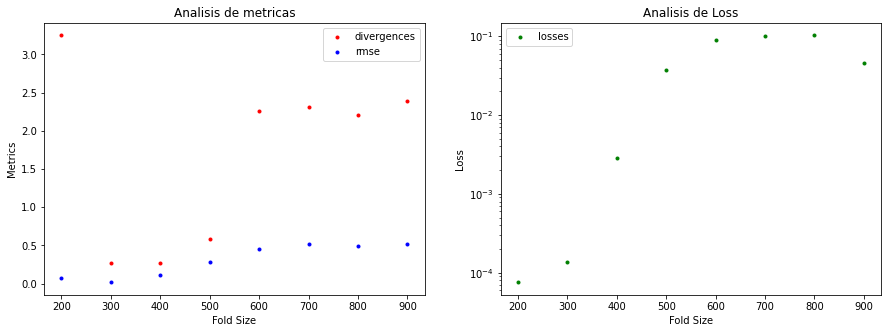

In [29]:
fold_sizes = losses.keys()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(fold_sizes, divergences.values(), color = 'r', linewidth=0, marker='.', label='divergences')
ax[0].plot(fold_sizes, rmses, color = 'b', linewidth=0, marker='.', label='rmse')
ax[1].set_yscale('log')
ax[0].set_ylabel('Metrics')
ax[0].set_xlabel('Fold Size')
ax[0].set_title('Analisis de metricas')
ax[0].legend()


ax[1].plot(fold_sizes, losses.values(), color = 'g', linewidth=0, marker='.', label='losses')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].set_xlabel('Fold Size')
ax[1].set_title('Analisis de Loss')
ax[1].legend()

plt.show()

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_65541/4268148296.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/susceptible.png', format='png', linewidth = 0.01)


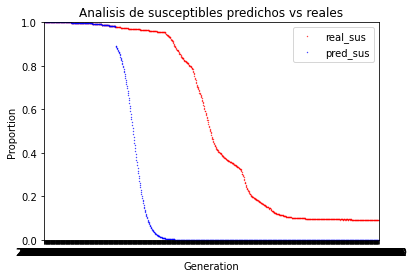

In [30]:
predicted_susceptible = res[:,0].detach().numpy()
real_susceptible = y[:,0].detach().numpy()
plt.plot(data.index, real_susceptible, color = 'r', linewidth=0, marker='.', markersize=0.7, label='real_sus')
plt.plot(data.index[1:], predicted_susceptible, color = 'b', linewidth=0, marker='.', markersize=0.7, label='pred_sus')
plt.ylim(0, 1)
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de susceptibles predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/susceptible.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_65541/2774136346.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/exposed.png', format='png', linewidth = 0.01)


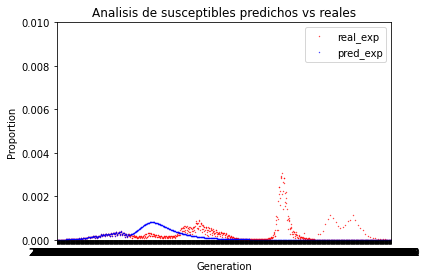

In [31]:
predicted_exposed = res[:,1].detach().numpy()
real_exposed = y[:,1].detach().numpy()
plt.plot(data.index, real_exposed, color = 'r', linewidth=0, marker='.', markersize=0.7, label='real_exp')
plt.plot(data.index[1:], predicted_exposed, color = 'b', linewidth=0, marker='.', markersize=0.7, label='pred_exp')
plt.ylim(0, 0.01)
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de susceptibles predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/exposed.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_65541/3171327945.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/infected.png', format='png', linewidth = 0.01)


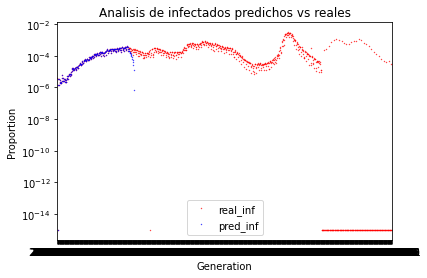

In [32]:
predicted_infected = res[:,2].detach().numpy()
real_infected = y[:,2].detach().numpy()
plt.plot(data.index, real_infected, color = 'r', linewidth=0, marker='.', markersize=0.7, label='real_inf')
plt.plot(data.index[1:], predicted_infected, color = 'b', linewidth=0, marker='.', markersize=0.7, label='pred_inf')
plt.yscale('log')
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de infectados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/infected.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_65541/344095273.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/recovered.png', format='png', linewidth = 0.01)


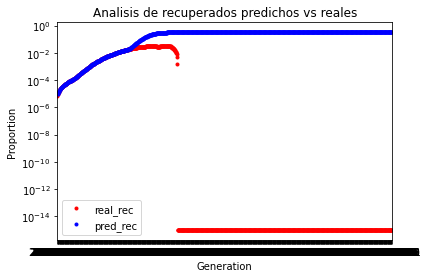

In [33]:
predicted_recov = res[:,3].detach().numpy()
real_recov = y[:,3].detach().numpy()
plt.plot(data.index, real_recov, color = 'r', linewidth=0, marker='.', label='real_rec')
plt.plot(data.index[1:], predicted_recov, color = 'b', linewidth=0, marker='.', label='pred_rec')
plt.yscale('log')
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de recuperados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/recovered.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_65541/193235953.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/deaths.png', format='png', linewidth = 0.01)


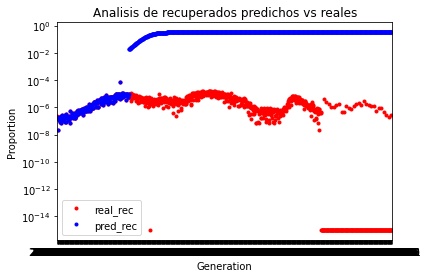

In [34]:
predicted_deaths = res[:,4].detach().numpy()
real_deaths = y[:,4].detach().numpy()
plt.plot(data.index, real_deaths, color = 'r', linewidth=0, marker='.', label='real_rec')
plt.plot(data.index[1:], predicted_deaths, color = 'b', linewidth=0, marker='.', label='pred_rec')
plt.yscale('log')
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de recuperados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/deaths.png', format='png', linewidth = 0.01)

/var/folders/g0/jqvp4xxs5pn4cds1xb9339xm0000gn/T/ipykernel_65541/4020870554.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "linewidth" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'figures/{enfermedad}/vaccinated.png', format='png', linewidth = 0.01)


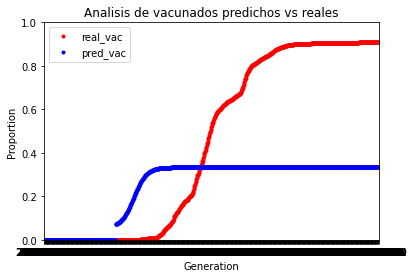

In [35]:
predicted_vaccinated = res[:,5].detach().numpy()
real_vaccinated = y[:,5].detach().numpy()
plt.plot(data.index, real_vaccinated, color = 'r', linewidth=0, marker='.', label='real_vac')
plt.plot(data.index[1:], predicted_vaccinated, color = 'b', linewidth=0, marker='.', label='pred_vac')
plt.ylim(0, 1)
plt.xlim(0,len(y))
plt.ylabel('Proportion')
plt.xlabel('Generation')
plt.title('Analisis de vacunados predichos vs reales')
plt.legend()
plt.savefig(f'figures/{enfermedad}/vaccinated.png', format='png', linewidth = 0.01)

Testeemos los parametros

In [36]:
params = list(model.parameters())
lambda1 = params[0].item()
lambda2 = params[1].item()
lambda3 = params[2].item()
print(params)

[Parameter containing:
tensor([[-0.0561]], requires_grad=True), Parameter containing:
tensor([[0.0553]], requires_grad=True), Parameter containing:
tensor([[-0.0393]], requires_grad=True), Parameter containing:
tensor([[0.0340]], requires_grad=True), Parameter containing:
tensor([[0.0613]], requires_grad=True)]


Recordemos que estamos modelando:

$$\dfrac{ds}{dt} = -\lambda_1 s i - \lambda_2 s  $$
\
$$\dfrac{di}{dt} = \lambda_1 s i - \lambda_3 i - \lambda_2 i  $$

\
$$\dfrac{dr}{dt} = \lambda_3 i  $$
\
$$\dfrac{dv}{dt} = \lambda_2 s + \lambda_2 i   $$



Entonces

$$\beta = \lambda_1 = R_0 / d $$

Con d la duración de la infeccion.

$$ \lambda_2 = \eta $$ la tasa de inmunización y

$$ \lambda_3 = \nu  = 1 / d $$

Primero veamos la tasa de immunizacion

In [41]:
tasa_immunizacion = (data.apply(lambda x: x.diff()).dropna().mean()/data['vaccinated'].max()).iloc[3]

In [42]:
tasa_immunizacion

-8.15630755630967e-09

In [43]:
from IPython.display import Latex
Latex(f"""Deducimos que:
$$ \eta = \lambda_2 = {{{lambda2:.5f}}} \\approx {{{tasa_immunizacion:.5f}}} $$""")

<IPython.core.display.Latex object>

In [44]:
Latex(f"""Deducimos que:
$$ d = 1 / \lambda_3 = 1 / {{{lambda3:.2f}}} \\approx {{{1/lambda3:.2f}}} $$
$$ R_0 =  \lambda_1 * d = {{{lambda1:.2f}}} * d \\approx {{{lambda1/lambda3:.2f}}}$$""")

<IPython.core.display.Latex object>

Mientras que la literatura indica:

$$ d = 17.5 $$
$$ R_0 = 2.65 $$

## Validemos un test de momentos

#### Primer momento

In [45]:
import scipy

scipy.stats.ttest_ind(real_susceptible, predicted_susceptible, equal_var=False)

Ttest_indResult(statistic=14.955188200594092, pvalue=7.698578117502175e-48)

In [46]:
scipy.stats.ttest_ind(real_infected, predicted_infected, equal_var=False)

Ttest_indResult(statistic=15.111003565120738, pvalue=1.3395364248019121e-46)

In [47]:
scipy.stats.ttest_ind(real_recov, predicted_recov, equal_var=False)

Ttest_indResult(statistic=-52.48914296882504, pvalue=5.3733160630176076e-282)

In [48]:
scipy.stats.ttest_ind(real_vaccinated, predicted_vaccinated, equal_var=False)

Ttest_indResult(statistic=14.516685101413797, pvalue=5.601071423401968e-44)

In [49]:
scipy.stats.ttest_ind(real_deaths, predicted_deaths, equal_var=False)

Ttest_indResult(statistic=-52.89474964007926, pvalue=4.791003222665573e-283)

In [50]:
scipy.stats.ttest_ind(real_exposed, predicted_exposed, equal_var=False)

Ttest_indResult(statistic=6.214417216104134, pvalue=6.765995155208847e-10)

#### Test de bondad de ajuste de KS

In [51]:
scipy.stats.kstest(real_susceptible, predicted_susceptible, method='asymp')

KstestResult(statistic=0.6905781584582441, pvalue=1.3570614439918976e-222)

In [52]:
scipy.stats.kstest(real_infected, predicted_infected, method='asymp')

KstestResult(statistic=0.7708779443254818, pvalue=5.066019509584926e-292)

In [53]:
scipy.stats.kstest(real_recov, predicted_recov, method='asymp')

KstestResult(statistic=0.7740899357601713, pvalue=3.3867230469443057e-295)

In [54]:
scipy.stats.kstest(real_vaccinated, predicted_vaccinated, method='asymp')

KstestResult(statistic=0.5315508021390374, pvalue=1.0684402942303066e-123)

In [55]:
scipy.stats.kstest(real_deaths, predicted_deaths, method='asymp')

KstestResult(statistic=0.786939046593915, pvalue=2.812893624077269e-308)

In [56]:
scipy.stats.kstest(real_exposed, predicted_exposed, method='asymp')

KstestResult(statistic=0.22943008622565242, pvalue=4.317984723306303e-22)